In [1]:
from network import Net
from trainers import *
from validator import *
import numpy as np
import pandas as pd

In [2]:
#load data TRAIN
data = pd.read_csv('..\datasets\cup\ML-CUP24-TR.csv', header=None, skiprows=7)
data = data.to_numpy()

#split data in train 80% and test 20%
np.random.shuffle(data)
train = data[:int(len(data)*0.8)]
test = data[int(len(data)*0.8):]

#split in x and y
x_train = train[:,1:-3]
y_train = train[:,-3:]
x_test = test[:,1:-3]
y_test = test[:,-3:]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(200, 12)
(200, 3)
(50, 12)
(50, 3)


In [3]:
network = Net('./config_cup.yaml')
network.print_structure()

Layer 1: Units = 768, Activation = relu
Layer 2: Units = 768, Activation = relu
Layer 3: Units = 3, Activation = identity


In [5]:
# first grid search
valid = Validator('param_grid_cup.yaml')
print(len(valid.grid))

best_configuration = valid.grid_search(x_train, y_train, network)
best_configuration

648


100%|██████████| 648/648 [1:40:58<00:00,  9.35s/it]


{'conf': {'activations': ['relu', 'relu', 'identity'],
  'alpha': 0.9,
  'eta': 0.001,
  'initializer': 'he',
  'lambd': 1e-05,
  'units': [1024, 1024, 3]},
 'epochs': 402,
 'metrics': np.float64(4.077944746740005)}

In [4]:
#second grid search, fine grained
valid = Validator('param_grid_cup2.yaml')
print(len(valid.grid))

best_configuration = valid.grid_search(x_train, y_train, network)
best_configuration

81


100%|██████████| 81/81 [12:21<00:00,  9.15s/it]


{'conf': {'activations': ['relu', 'relu', 'identity'],
  'alpha': 0.8,
  'eta': 0.001,
  'initializer': 'he',
  'lambd': 5e-06,
  'units': [768, 768, 3]},
 'epochs': 303,
 'metrics': np.float64(3.828270287911239)}

Layer 1: Units = 768, Activation = relu
Layer 2: Units = 768, Activation = relu
Layer 3: Units = 3, Activation = identity


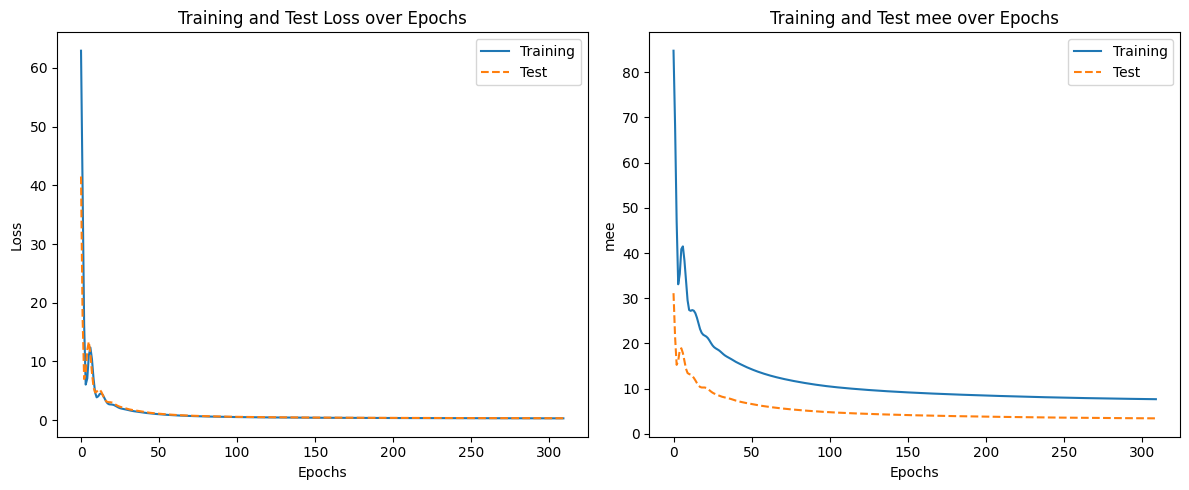

train_loss  :  0.30362661073388736
test_loss  :  0.3252591894781201
train_metric  :  7.657220408319032
test_metric  :  3.420983826942635


In [26]:
network.set_best_configuration(best_configuration)
network.print_structure()

results = train_and_evaluate(x_train, y_train, x_test, y_test, network.get_W(), network.get_b(), network.get_layers(), network.get_hyperparameters())

for key in results.keys():
    if key != 'model':
        print(key, ' : ', results[key])

In [9]:
# Retrain the model using all the data
data = pd.read_csv('..\datasets\cup\ML-CUP24-TR.csv', header=None, skiprows=7)
data = data.to_numpy()
np.random.shuffle(data)

#split in x and y
x_train = data[:,1:-3]
y_train = data[:,-3:]

print(x_train.shape)
print(y_train.shape)

(250, 12)
(250, 3)


In [10]:
network = Net('./config_cup.yaml')
network.print_structure()

final_model = train_model(x_train, y_train, network.get_W(), network.get_b(), network.get_layers(), network.get_hyperparameters())

Layer 1: Units = 768, Activation = relu
Layer 2: Units = 768, Activation = relu
Layer 3: Units = 3, Activation = identity


In [11]:
#load data TEST
data_TS = pd.read_csv('..\datasets\cup\ML-CUP24-TS.csv', header=None, skiprows=7)
data_TS = data_TS.to_numpy()
x_TS = data_TS[:,1:]
print(x_TS.shape)

cup_labels = blind_test(x_TS, final_model[0], final_model[1], network.get_layers())
#save cup_labels in a csv file
np.savetxt("cup_labels.csv", cup_labels, delimiter=",")
# print the first 10 labels
print(cup_labels[:10])

(500, 12)
[[ 2.58753903e-01 -2.34282121e+00  2.72976906e+01]
 [-4.76671536e-01  1.44170297e+00  2.57250073e+01]
 [ 1.15210053e+00 -5.08035964e-03 -1.48200387e+01]
 [ 2.21485815e-01 -4.00836222e-02 -3.88676397e+00]
 [ 2.69154501e-02  1.39931514e-01  3.15953028e+00]
 [-1.29684535e+00 -1.64688569e+00  3.45111353e+01]
 [ 2.54261134e-01 -5.08820563e-01  5.34361686e+00]
 [-4.25842989e-01 -3.95525501e-01 -6.26708057e+00]
 [-1.66785576e+00 -1.63915754e-01  1.57627934e+01]
 [-6.79703011e-01  5.73991103e-01  8.81570982e+00]]


In [27]:
#load cup_labels from file
cup_labels = np.loadtxt('cup_labels.csv', delimiter=',')

#add a first column with the index
index = np.arange(1, len(cup_labels)+1)
cup_labels = np.column_stack((index, cup_labels))

#save cup_labels in a csv file named TheHermit_ML-CUP24-TS.csv
np.savetxt("TheHermit_ML-CUP24-TS.csv", cup_labels, delimiter=",", fmt='%i,%f,%f,%f')